In [ ]:
!git clone https://github.com/CityScope/CSL_HCMC.git

Cloning into 'CSL_HCMC'...
remote: Enumerating objects: 1560, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 1560 (delta 97), reused 191 (delta 93), pack-reused 1340
Receiving objects: 100% (1560/1560), 151.55 MiB | 24.86 MiB/s, done.
Resolving deltas: 100% (774/774), done.
Checking out files: 100% (485/485), done.


In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy

In [ ]:
!pip install osmnet
!pip install cs-brix
!pip install matplotlib==3.1.3
!pip install osmnet
!pip install pandana
!pip install folium

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Read wards, POIs, buildings, house price and filter data for district 4

In [ ]:
data_path = "CSL_HCMC/Data/GIS/"
pop_path = data_path + 'Population/population_HCMC/population_shapefile/'
wards = gpd.read_file(pop_path + 'Population_Ward_Level.shp')
districts = gpd.read_file(pop_path + 'Population_District_Level.shp')
dist4_wards = wards[wards['Dist_Name'] == 'District 4']

In [ ]:
poi_path = data_path + 'POI/POI_model_area/shapefile/'
all_pois = {'medical' : gpd.read_file(poi_path + 'Merdical.shp'),
        'park' : gpd.read_file(poi_path + 'GreeneryPark.shp'),
        'education' : gpd.read_file(poi_path + 'Education.shp'),
        'commercial' : gpd.read_file(poi_path + 'Commercial_Services.shp')}
amenities = ['medical', 'park', 'education', 'commercial']

In [ ]:
all_buildings = {i: gpd.read_file(data_path + 'Scenario{}/Building_scenario_{}/calculating/Building_{}.shp'.format(i,i,i)) for i in [0, 3]}
all_buildings[2] = gpd.read_file(data_path + 'Scenario{}/Building_Scenario_{}/calculating/Building_{}.shp'.format(2,2,2))

In [ ]:
dist4 = districts[districts['Dist_Name']=='District 4']
dist4_buildings = {idx : all_buildings[idx][all_buildings[idx].within(dist4.geometry.values[0])] for idx in [0, 2, 3]}

In [ ]:
#all landuse
all_landuse = {i: gpd.read_file(data_path + 'Scenario{}/Landuse_scenario_{}/LandUse_{}.shp'.format(i,i,i)) for i in [0, 3]}
all_landuse[2] = gpd.read_file(data_path + 'Scenario{}/LandUse_Scenario_{}/LandUse_{}.shp'.format(2,2,2))

dist4_landuse = {idx : all_landuse[idx][all_landuse[idx].within(dist4.geometry.values[0])] for idx in [0, 2, 3]}

### CityScope Spatial Urban Analysis

In [ ]:
# low_buildings = {idx: dist4_buildings[idx][dist4_buildings[idx]['CSLLandTyp']=='Residential - lowrise'] for idx in [0,2,3]}
# high_buildings = {idx: dist4_buildings[idx][dist4_buildings[idx]['CSLLandTyp']=='Residential - highrise'] for idx in [0,2,3]}
# mixed_buildings = {idx: dist4_buildings[idx][dist4_buildings[idx]['CSLLandTyp']=='Mixed-use'] for idx in [0,2,3]}

### Filter district areas in simulation boundary

In [ ]:
from shapely.geometry import Polygon
sim_bound = all_buildings[0].total_bounds
sim_bound = Polygon([[sim_bound[0], sim_bound[3]], [sim_bound[0], sim_bound[1]], [sim_bound[2], sim_bound[1]], [sim_bound[2], sim_bound[3]]])

sim_districts = {i: districts[districts['Dist_Name']=='District {}'.format(i)] for i in [1, 2, 4, 7]}
sim_district_areas = {i: sim_districts[i].geometry.values[0].intersection(sim_bound).area for i in [1, 2, 4, 7]}

# Density Indicator

## Housing Density

Computer raw desity for each district

In [ ]:
sim_low_buildings = {}
sim_high_buildings = {}
sim_mix_buildings = {}

for dist_idx in [1, 2, 4, 7]:
  sim_low_buildings[dist_idx] = {}
  sim_high_buildings[dist_idx] = {}
  sim_mix_buildings[dist_idx] = {}
  for sim_idx in [0,2,3]:
    # Lay building trong district
    building_in_dist = all_buildings[sim_idx][all_buildings[sim_idx].within(sim_districts[dist_idx].geometry.values[0])]
    # Lay building low va high
    high_building = building_in_dist[building_in_dist['CSLLandTyp'] =='Residential - highrise']
    low_building = building_in_dist[building_in_dist['CSLLandTyp'] =='Residential - lowrise']
    mix_building = building_in_dist[building_in_dist['CSLLandTyp'] =='Mixed use']
    
    sim_low_buildings[dist_idx][sim_idx] = low_building
    sim_high_buildings[dist_idx][sim_idx] = high_building
    sim_mix_buildings[dist_idx][sim_idx] = mix_building

In [ ]:
housing_density = {}
all_densities = []
for dist_idx in [1, 2, 4, 7]:
  housing_density[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    # So don vi o nha thap tang
    num_low = len(sim_low_buildings[dist_idx][sim_idx])

    # So don vi o nha cao tang 
    sim_high_buildings[dist_idx][sim_idx]['Shape_Area']
    num_high = sum(sim_high_buildings[dist_idx][sim_idx]['Shape_Area']*sim_high_buildings[dist_idx][sim_idx]['Storey'])/ 80
    
    # So don vi o cua khu Mixed-use
    num_mix_high = sum(sim_mix_buildings[dist_idx][sim_idx]['Shape_Area']*0.7*sim_mix_buildings[dist_idx][sim_idx]['Storey'])/ 80  #Dien tich de xay chung cu
    num_mix_low = sum(sim_mix_buildings[dist_idx][sim_idx]['Shape_Area']*0.3)/ 80  #Dien tich de xay nha pho
    housing_density[dist_idx][sim_idx] = (num_low + num_mix_low + num_high + num_mix_high)/ sim_district_areas[dist_idx]
    all_densities.append(housing_density[dist_idx][sim_idx])

In [ ]:
housing_density

{1: {0: 0.015546895434084437,
  2: 0.015546895434084437,
  3: 0.015546895434084437},
 2: {0: 0.0036189943898336896,
  2: 0.0036189943898336896,
  3: 0.0036189943898336896},
 4: {0: 0.011288243953155041, 2: 0.01250929573303063, 3: 0.011868301607094772},
 7: {0: 0.0054488086569747605,
  2: 0.0054488086569747605,
  3: 0.0054488086569747605}}

In [ ]:
def normalise_indicator(raw_value, min_value, max_value):
    return (raw_value-min_value)/(max_value-min_value)

In [ ]:
min_dens = min(all_densities)
print('Min density: ', min_dens)
max_dens = max(all_densities)
print('Max density: ', max_dens)

norm_housing_density = {}
for dist_idx in [1, 2, 4, 7]:
  norm_housing_density[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    norm_housing_density[dist_idx][sim_idx] = normalise_indicator(housing_density[dist_idx][sim_idx], min_dens, max_dens)
print('Housing density: ')
norm_housing_density

Min density:  0.0036189943898336896
Max density:  0.015546895434084437
Housing density: 


{1: {0: 1.0, 2: 1.0, 3: 1.0},
 2: {0: 0.0, 2: 0.0, 3: 0.0},
 4: {0: 0.6429672358002947, 2: 0.7453366112122525, 3: 0.6915975565740673},
 7: {0: 0.15340622464528594, 2: 0.15340622464528594, 3: 0.15340622464528594}}

## Amenity Density

In [ ]:
amenity_density = {}
all_amenity_densities = []

for dist_idx in [1, 2, 4, 7]:
  amenity_density[dist_idx] = {}

  commercial_pois = all_pois['commercial'][all_pois['commercial']['District'] == 'District {}'.format(dist_idx)]
  education_pois = all_pois['education'][all_pois['education']['District'] == 'District {}'.format(dist_idx)]
  park_pois = all_pois['park'][all_pois['park']['District'] == 'District {}'.format(dist_idx)]
  medical_pois = all_pois['medical'][all_pois['medical']['District'] == 'District {}'.format(dist_idx)]

  amenity_density[dist_idx] = (len(commercial_pois) + len(education_pois) + len(park_pois) + len(medical_pois)) / sim_district_areas[dist_idx]
  all_amenity_densities.append(amenity_density[dist_idx])
all_amenity_densities

[0.00036551830798935966,
 1.9545349698917823e-05,
 0.00035274394346542865,
 0.0002851929759898346]

In [ ]:
min_amenity_dens = min(all_amenity_densities)
print('Min amenity_density: ', min_amenity_dens)
max_amenity_dens = max(all_amenity_densities)
print('Max amenity_density: ', max_amenity_dens)

norm_amenity_density = {}
for dist_idx in [1, 2, 4, 7]:
  norm_amenity_density[dist_idx] = {}
  norm_amenity_density[dist_idx]= normalise_indicator(amenity_density[dist_idx], min_amenity_dens, max_amenity_dens)
print('Amenity density: ')
norm_amenity_density

Min amenity_density:  1.9545349698917823e-05
Max amenity_density:  0.00036551830798935966
Amenity density: 


{1: 1.0, 2: 0.0, 4: 0.9630769855914374, 7: 0.7678277157947919}

## Employment/Job Density

In [ ]:
#compute full attributes of all districts
dist = {}
dist_full_attr_buildings = {}
dist_buildings = {}

for dist_idx in [1, 2, 4, 7]:
  dist_full_attr_buildings[dist_idx] = {}
  dist[dist_idx] = {}
  dist_buildings[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    print('Calculating full attributes for district {} in scenario {}'.format(dist_idx, sim_idx))
    dist[dist_idx][sim_idx] = districts[districts['Dist_Name']=='District {}'.format(dist_idx)]
    dist_buildings[dist_idx][sim_idx] = all_buildings[sim_idx][all_buildings[sim_idx].within(dist[dist_idx][sim_idx].geometry.values[0])]

    dist_full_attr_buildings[dist_idx][sim_idx] = dist_buildings[dist_idx][sim_idx].apply(lambda row: building_to_attributes(row, types), axis=1).fillna(0)


Calculating full attributes for district 1 in scenario 0
Calculating full attributes for district 1 in scenario 2
Calculating full attributes for district 1 in scenario 3
Calculating full attributes for district 2 in scenario 0
Calculating full attributes for district 2 in scenario 2
Calculating full attributes for district 2 in scenario 3
Calculating full attributes for district 4 in scenario 0
Calculating full attributes for district 4 in scenario 2
Calculating full attributes for district 4 in scenario 3
Calculating full attributes for district 7 in scenario 0
Calculating full attributes for district 7 in scenario 2
Calculating full attributes for district 7 in scenario 3


In [ ]:
emp_density = {}
all_emp_densities = []

for dist_idx in [1, 2, 4, 7]:
  emp_density[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    print('Calculating density of emp for district {} in scenario {}'.format(dist_idx, sim_idx))
    
    #density follow MIT
    agg_site = dist_full_attr_buildings[dist_idx][sim_idx].sum(axis=0)
    emp_density[dist_idx][sim_idx] = agg_site['emp_total']/agg_site['Shape_Area']
    all_emp_densities.append(emp_density[dist_idx][sim_idx])
    print(emp_density[dist_idx][sim_idx])

Calculating density of emp for district 1 in scenario 0
0.20381027888376044
Calculating density of emp for district 1 in scenario 2
0.20381027888376044
Calculating density of emp for district 1 in scenario 3
0.20381027888376044
Calculating density of emp for district 2 in scenario 0
0.3998132829035768
Calculating density of emp for district 2 in scenario 2
0.3998132829035768
Calculating density of emp for district 2 in scenario 3
0.3998132829035768
Calculating density of emp for district 4 in scenario 0
0.07511973620560533
Calculating density of emp for district 4 in scenario 2
0.08371848922733661
Calculating density of emp for district 4 in scenario 3
0.10944543057111396
Calculating density of emp for district 7 in scenario 0
0.033312782570718964
Calculating density of emp for district 7 in scenario 2
0.033312782570718964
Calculating density of emp for district 7 in scenario 3
0.033312782570718964


In [ ]:
min_emp_dens = min(all_emp_densities)
print('Min emp: ', min_emp_dens)
max_emp_dens = max(all_emp_densities)
print('Max emp: ', max_emp_dens)

norm_emp_density = {}
for dist_idx in [1, 2, 4, 7]:
  norm_emp_density[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    norm_emp_density[dist_idx][sim_idx] = normalise_indicator(emp_density[dist_idx][sim_idx], min_emp_dens, max_emp_dens)
print('Employment density: ')
norm_emp_density

Min emp:  0.033312782570718964
Max emp:  0.3998132829035768
Employment density: 


{1: {0: 0.4652039933320546, 2: 0.4652039933320546, 3: 0.4652039933320546},
 2: {0: 1.0, 2: 1.0, 3: 1.0},
 4: {0: 0.11407065910392224, 2: 0.13753243613811958, 3: 0.20772863319763787},
 7: {0: 0.0, 2: 0.0, 3: 0.0}}

# Diversity Indicator

## Housing Diversity

In [ ]:
import math
from scipy.spatial import cKDTree

def get_diversity(species_counts):
    num_species= len(species_counts)
    
    diversity=0
    pop_size=sum(species_counts) #mean what? total number of species
    # print(pop_size)
    if ((len(species_counts)>1) and (pop_size>0)):        
        for count in species_counts: #for each species in many species
            pj=count/pop_size #compute pj
            if not pj==0:
                diversity+= -pj*math.log(pj) #H
        equitability=diversity/math.log(len(species_counts)) #H per a one species
        return equitability
    else:
        return float('nan')

In [ ]:
price_path = data_path + 'Price/building_price_shapefile/'
house_price = {idx: gpd.read_file(price_path + 'Building_Price_{}.shp'.format(idx)) for idx in [0, 2, 3]}

In [ ]:
import pandas as pd

for sim_idx in [0, 2, 3]:
  for house_type in ['Residential - lowrise', 'Residential - highrise', 'Mixed use']:
    house_unk_price = house_price[sim_idx][(house_price[sim_idx].CSLLandTyp==house_type) & (house_price[sim_idx].Price==0)]
    ref_house_price = house_price[sim_idx][(house_price[sim_idx].CSLLandTyp==house_type) & (house_price[sim_idx].Price>0)]
    others = house_price[sim_idx][house_price[sim_idx].CSLLandTyp!=house_type]

    nA = np.array(list(house_unk_price.geometry.centroid.apply(lambda p: (p.x, p.y))))
    nB = np.array(list(ref_house_price.geometry.centroid.apply(lambda p: (p.x, p.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    for loc in range(len(idx)):
      house_unk_price.Price.iloc[loc] = ref_house_price.Price.iloc[idx[loc]] * 0.6
    house_price[sim_idx] = pd.concat([house_unk_price, ref_house_price, others], axis=0)


In [ ]:
def building_to_prices(row):
    total_building_price = row['Storey']*row['B_Area']*row['Price'] #estimate total construction area of a building
    #total_building_price += storeys*500
    row['townhouse_price']=total_building_price
    return row

def building_to_price_group(row, min_p, max_p, rates):
    cat = -1
    left = min_p
    for irate in range(len(rates)):
      right = left+(max_p-min_p)*rates[irate]
      if row['townhouse_price'] >= left and row['townhouse_price'] < right:
        cat = irate
      left = right
    if cat == -1:
      cat = len(rates)-1
    row['price_group'] = cat
    return row

def apartment_to_price_group(row, min_p, max_p, rates):
    cat = -1
    left = min_p
    for irate in range(len(rates)):
      right = left+(max_p-min_p)*rates[irate]
      if row['Price'] >= left and row['Price'] < right:
        cat = irate
      left = right
    if cat == -1:
      cat = len(rates)-1
    row['price_group'] = cat
    row['num_apart'] = row['Shape_Area_left']*row['Storey']/80.0
    return row


In [ ]:
from geopandas.tools import sjoin

housing_diversity = {4:{}}
for sim_idx in [0, 2, 3]:
  rates = [1/6.0, 2/6.0, 3/6.0]
  nhouses_pcat = []
  # low-rise
  building_with_price = sjoin(dist4_buildings[sim_idx], house_price[sim_idx], how="left", op="within")
  low_buildings = building_with_price[building_with_price['CSLLandTyp_left']=='Residential - lowrise']
  high_buildings = building_with_price[building_with_price['CSLLandTyp_left']=='Residential - highrise']
  mixed_buildings = building_with_price[building_with_price['CSLLandTyp_left']=='Mixed use']
  
  low_building_with_price = low_buildings.apply(lambda row: building_to_prices(row), axis=1).fillna(0)
  max_price = low_building_with_price.max()['townhouse_price']
  min_price = low_building_with_price.min()['townhouse_price']
  low_building_with_price = low_building_with_price.apply(lambda row: building_to_price_group(row, min_price, max_price, rates), axis=1).fillna(0)
  # Mixed use
  rates = [1/3.0, 1/3.0, 1/3.0]
  nhouses_pcat.append(len(low_building_with_price[low_building_with_price['price_group']==0]))
  nhouses_pcat.append(len(low_building_with_price[low_building_with_price['price_group']==1]))
  nhouses_pcat.append(len(low_building_with_price[low_building_with_price['price_group']==2]))
  # High rise
  max_price = mixed_buildings.max()['Price']
  min_price = mixed_buildings.min()['Price']
  mixed_buildings_with_cat = mixed_buildings.apply(lambda row: apartment_to_price_group(row, min_price, max_price, rates), axis=1).fillna(0)
  nhouses_pcat.append(0.7*mixed_buildings_with_cat[mixed_buildings_with_cat['price_group']==0].sum()['num_apart'])
  nhouses_pcat.append(0.7*mixed_buildings_with_cat[mixed_buildings_with_cat['price_group']==1].sum()['num_apart'])
  nhouses_pcat.append(0.7*mixed_buildings_with_cat[mixed_buildings_with_cat['price_group']==2].sum()['num_apart'])

  max_price = high_buildings.max()['Price']
  min_price = high_buildings.min()['Price']
  if math.isnan(max_price):
    housing_diversity[4][sim_idx] = get_diversity(nhouses_pcat)
    continue
  high_buildings_with_cat = high_buildings.apply(lambda row: apartment_to_price_group(row, min_price, max_price, rates), axis=1).fillna(0)
  nhouses_pcat[-3]+= high_buildings_with_cat[high_buildings_with_cat['price_group']==0].sum()['num_apart']
  nhouses_pcat[-2]+= high_buildings_with_cat[high_buildings_with_cat['price_group']==1].sum()['num_apart']
  nhouses_pcat[-1]+= high_buildings_with_cat[high_buildings_with_cat['price_group']==2].sum()['num_apart']
  
  housing_diversity[4][sim_idx] = get_diversity(nhouses_pcat)

In [ ]:
#OLD: housing_diversity
#{4: {0: 0.545877741592074, 2: 0.6353768963206002, 3: 0.6172825887486035}}
housing_diversity
#nhouses_pcat

{4: {0: 0.5513025348880799, 2: 0.6592748582270818, 3: 0.6372605094311808}}

In [ ]:
housing_diversity = {}

for dist_idx in [1, 2, 4, 7]:
  housing_diversity[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    # So don vi o nha thap tang
    num_low = len(sim_low_buildings[dist_idx][sim_idx])

    # So don vi o nha cao tang 
    sim_high_buildings[dist_idx][sim_idx]['Shape_Area']
    num_high = sum(sim_high_buildings[dist_idx][sim_idx]['Shape_Area']*sim_high_buildings[dist_idx][sim_idx]['Storey'])/ 80
    
    # So don vi o cua khu Mixed-use
    num_mix_high = sum(sim_mix_buildings[dist_idx][sim_idx]['Shape_Area']*0.7*sim_mix_buildings[dist_idx][sim_idx]['Storey'])/ 80  #Dien tich de xay chung cu
    num_mix_low = sum(sim_mix_buildings[dist_idx][sim_idx]['Shape_Area']*0.3)/ 80  #Dien tich de xay nha pho
    housing_diversity[dist_idx][sim_idx] = get_diversity([num_low, num_mix_low, num_high + num_mix_high])
    

In [ ]:
# Mount to save result
from google.colab import drive
drive.mount('/content/drive')
result_path = '/content/drive/MyDrive/3.Project/6.ARC-MIT/Result'

Mounted at /content/drive


## Amenity Diversity

In [ ]:
amenity_diversity = {}

for dist_idx in [1, 2, 4, 7]:
  amenity_diversity[dist_idx] = {}

  commercial_pois = all_pois['commercial'][all_pois['commercial']['District'] == 'District {}'.format(dist_idx)]
  education_pois = all_pois['education'][all_pois['education']['District'] == 'District {}'.format(dist_idx)]
  park_pois = all_pois['park'][all_pois['park']['District'] == 'District {}'.format(dist_idx)]
  medical_pois = all_pois['medical'][all_pois['medical']['District'] == 'District {}'.format(dist_idx)]

  amenity_diversity[dist_idx] = get_diversity([len(commercial_pois), len(education_pois), len(park_pois), len(medical_pois)])

amenity_diversity

{1: 0.16376270231119844,
 2: 0.07687109016438094,
 4: 0.16921554953852308,
 7: 0.07068552120091513}

## Employment/Job Diversity

In [ ]:
industry_columns = {}
emp_diversity = {}

for dist_idx in [1, 2, 4, 7]:
  industry_columns[dist_idx] = {}
  emp_diversity[dist_idx] = {}
  for sim_idx in [0, 2, 3]:
    print('Calculating diversity of emp for district {} in scenario {}'.format(dist_idx, sim_idx))
    
    #diversity follow MIT
    industry_columns[dist_idx][sim_idx] = [col for col in dist_full_attr_buildings[dist_idx][sim_idx].columns if 'emp_naics' in col]

    agg_site = dist_full_attr_buildings[dist_idx][sim_idx].sum(axis=0)
    emp_diversity[dist_idx][sim_idx] = get_diversity([agg_site[col] for col in industry_columns[dist_idx][sim_idx]]) 
    print(emp_diversity[dist_idx][sim_idx])

Calculating diversity of emp for district 1 in scenario 0
0.7943630572957392
Calculating diversity of emp for district 1 in scenario 2
0.7943630572957392
Calculating diversity of emp for district 1 in scenario 3
0.7943630572957392
Calculating diversity of emp for district 2 in scenario 0
0.7056630928947264
Calculating diversity of emp for district 2 in scenario 2
0.7056630928947264
Calculating diversity of emp for district 2 in scenario 3
0.7056630928947264
Calculating diversity of emp for district 4 in scenario 0
0.7637618494664363
Calculating diversity of emp for district 4 in scenario 2
0.7447191095272313
Calculating diversity of emp for district 4 in scenario 3
0.7328403253055698
Calculating diversity of emp for district 7 in scenario 0
0.6758740565049
Calculating diversity of emp for district 7 in scenario 2
0.6758740565049
Calculating diversity of emp for district 7 in scenario 3
0.6758740565049


# Live-Work Indicator

In [ ]:
import pandas
landtypes = pandas.read_csv(data_path + '../Table/cslhcmc-landtype-v4.csv')
landtypes = landtypes.rename(columns ={'NAICS_proportions':'NAICS_proportion'})
landtypes.columns

NameError: ignored

In [ ]:
def csv2json(typetable):
  types = {}
  for index in range(len(typetable)):
      #print(types[index])
      row = typetable[index:index+1]
      land_type = row['CSLLandtype'].values[0]
      types[land_type] = {}
      for attr in ['LBCS', 'NAICS']:
        types[land_type][attr] = {}
        codes = row[attr].values[0].split(', ')
        props = row[attr+'_proportion'].values[0].split(', ')
        sqm_pemp = row['Area per person (employee)\n(sqm/person)'].values[0].split(', ')
        sqm_pres = row['Area per person (resident)\n(sqm/person)'].values[0].split(', ')
        for idx, code in enumerate(codes):
          if code == 'Null':
            continue
          types[land_type][attr][code] = {}
          types[land_type][attr][code]['props'] = props[idx]
          if idx >= len(sqm_pemp):
            types[land_type][attr][code]['sqm_pemp'] = '0'
          else:
            types[land_type][attr][code]['sqm_pemp'] = sqm_pemp[idx]
          if idx >= len(sqm_pres):
            types[land_type][attr][code]['sqm_pres'] = '0'
          else:
            types[land_type][attr][code]['sqm_pres'] = sqm_pres[idx]
      
  return types

types = csv2json(landtypes)
types

In [ ]:
def aggregate_area_attributes(attribute, total_area, type_info, digits=None): #compute capacity per each considered attribute
    """
    Takes as input the total capacity of a parcel/cell, the type description
    and an attributes of interest (eg. NAICS)
    Returns the total capacities associated with that attribute
    optionally reduce the precision of an attribute such as NAICS by supplying digits=n
    """
    aggregated={}
    # print("type info ", type_info)
    if attribute not in type_info:
        #print('attribute1', attribute)
        return aggregated
    if type_info[attribute] is not 'Null':
        for code in type_info[attribute]:
            if digits==None:
                code_digits=code
            else:
                code_digits=code[0:digits]
            #print(type_info[attribute][code]['sqm_pres'])
            sqm_pres = float(type_info[attribute][code]['sqm_pres'])
            if sqm_pres == 0:
              sqm_pres = np.inf
            sqm_pemp = float(type_info[attribute][code]['sqm_pemp'])
            if sqm_pemp == 0:
              sqm_pemp = np.inf

            attr_capacity = total_area*float(type_info[attribute][code]['props'])*(1/sqm_pres+1/sqm_pemp)
            #print('cap', attr_capacity)
            if code_digits in aggregated:
                aggregated[code_digits]+= attr_capacity
            else:
                aggregated[code_digits]= attr_capacity
    return aggregated

In [ ]:
def building_to_attributes(row, types):
    name=row['CSLLandTyp']
    storeys=row['Storey']
    # print(storeys)
    type_info = types[name]
    
    total_area=storeys*row['Shape_Area'] #estimate total construction area of a building
    
    agg_naics=aggregate_area_attributes('NAICS', total_area, type_info, digits=2)
    
    agg_lbcs=aggregate_area_attributes('LBCS', total_area, type_info, digits=1)
    
    agg_res=aggregate_area_attributes('res_income', total_area, type_info, digits=None)
    
    for naics in agg_naics:
        row['emp_naics_{}'.format(naics)]=agg_naics[naics]   
    for res in agg_res:
        row['res_income{}'.format(res)]=agg_res[res]
    row['emp_total']=sum(agg_naics.values())
    
    if '1' in agg_lbcs:
        cell_population=agg_lbcs['1']
    else:
        cell_population=0
    row['res_total']=cell_population

    return row

In [ ]:
live_work_scores = {} #building based
for sim_idx in [0, 2, 3]:
  print('Calculating for scenario ', sim_idx)
  dist4_full_attr_buildings = dist4_buildings[sim_idx].apply(lambda row: building_to_attributes(row, types), axis=1).fillna(0)
  agg_building = dist4_full_attr_buildings.sum(axis=0)
  live_work_scores[sim_idx] = agg_building['res_total']/agg_building['emp_total']
  if live_work_scores[sim_idx] > 1:
    live_work_scores[sim_idx] = 1/live_work_scores[sim_idx]

live_work_scores

Calculating for scenario  0
Calculating for scenario  2
Calculating for scenario  3


{0: 0.4431096722060759, 2: 0.4588290386912325, 3: 0.6157112465602558}

In [ ]:
live_work_scores_lu = {} #landuse based
dist4_full_attr_lu = {}
for sim_idx in [0, 2, 3]:
  print('Calculating for scenario ', sim_idx)
  dist4_full_attr_lu[sim_idx] = dist4_landuse[sim_idx].apply(lambda row: building_to_attributes(row, types), axis=1).fillna(0)
  agg_building = dist4_full_attr_lu[sim_idx].sum(axis=0)
  live_work_scores_lu[sim_idx] = agg_building['res_total']/agg_building['emp_total']
  if live_work_scores_lu[sim_idx] > 1:
    live_work_scores_lu[sim_idx] = 1/live_work_scores_lu[sim_idx]

live_work_scores_lu

Calculating for scenario  0
Calculating for scenario  2
Calculating for scenario  3


{0: 0.664887570566735, 2: 0.6669772514631472, 3: 0.9242995113911376}

# Accessibility

In [ ]:
def compute_closest_distance(centroids, pois):
  distances = []
  for j in centroids:
    distances.append(np.min([j.distance(x) for x in pois['geometry']]))
  return distances

def compute_accessibility(centroids, pois, max_dist=500):
  accessibility = []
  circles = centroids.buffer(max_dist)
  for j in circles:
    accessibility.append(np.sum([j.contains(x) for x in pois['geometry']]))
  return accessibility

In [ ]:
from brix import Indicator, Handler
from brix.examples import Diversity, RandomIndicator
import random

grids = {}
for idx in [0, 2, 3]:
  H = Handler('hcm_scenario_{}'.format(idx), quietly=False)
  geo_data = H.get_geogrid_data(include_geometries=True)
  grids[idx] = geo_data.as_df().to_crs('EPSG:32648')

https://cityio.media.mit.edu/api/tables/list/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_0/meta/hashes/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_0/GEOGRIDDATA/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_0/GEOGRID/ Attempt: 0
https://cityio.media.mit.edu/api/tables/list/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_2/meta/hashes/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_2/GEOGRIDDATA/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_2/GEOGRID/ Attempt: 0
https://cityio.media.mit.edu/api/tables/list/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/meta/hashes/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/GEOGRIDDATA/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/GEOGRID/ Attempt: 0


In [ ]:
idx = 0
Acessibilities = {}
num_pois = {}
for amenity in amenities:
  print(amenity)
  pois = all_pois[amenity]
  num_pois[amenity] = len(pois)
  Acessibilities[amenity] = compute_accessibility(grids[idx].centroid, pois)
  

medical
park
education
commercial


In [ ]:
import numpy as np
avg_accessibility = {}

for amenity in amenities:
    avg = np.average(Acessibilities[amenity])
    avg_accessibility[amenity] = avg
    
avg_accessibility

{'commercial': 200.1969696969697,
 'education': 5.704750204750205,
 'medical': 2.6244881244881246,
 'park': 0.2620802620802621}

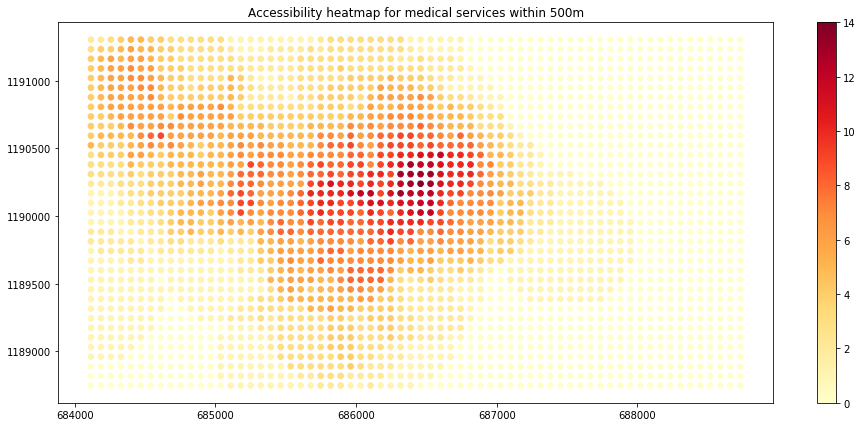

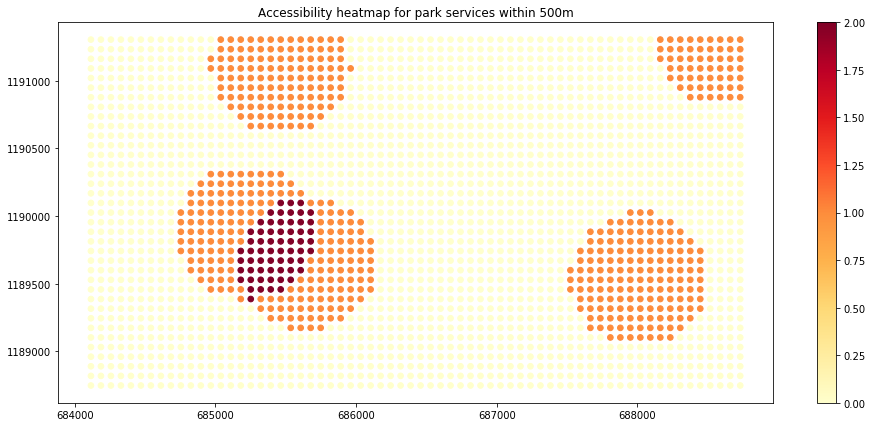

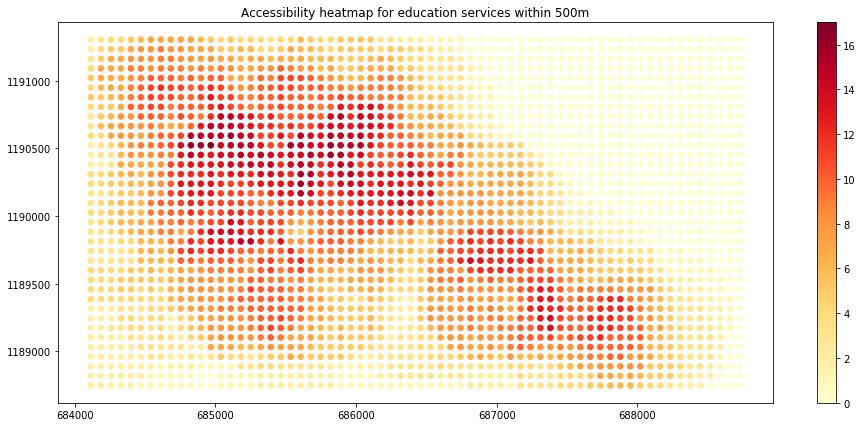

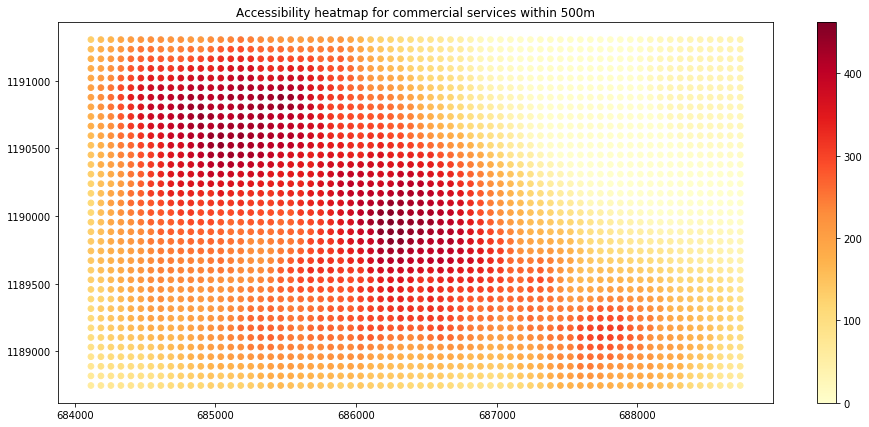

In [ ]:
for amenity in amenities:
    fig, ax = plt.subplots(figsize=(16,7))
    plt.title('Accessibility heatmap for {} services within 500m'.format(amenity))
    plt.scatter(grids[idx].centroid.geometry.x, grids[idx].centroid.geometry.y, 
                c=Acessibilities[amenity], s=32, cmap='YlOrRd')

    cb = plt.colorbar()
    plt.show()

# Mobility

In [ ]:
%cd "/content/CSL_HCMC/modules/"
!git clone https://github.com/CityScope/CS_Spatial_Modules.git

/content/CSL_HCMC/modules
Cloning into 'CS_Spatial_Modules'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 283 (delta 162), reused 209 (delta 91), pack-reused 0
Receiving objects: 100% (283/283), 5.02 MiB | 12.88 MiB/s, done.
Resolving deltas: 100% (162/162), done.


In [ ]:
# use the Simulation class from the CS_Spatial_Modules submodule

import sys
sys.path.insert(0,'../modules/CS_Spatial_Modules')
import Simulation

In [ ]:
all_zones=gpd.read_file('../outputs/zones.geojson').set_index('GEOID')

In [ ]:
import pandana
import osmnet

bbox=all_zones.total_bounds
nodes_df,edges_df=osmnet.load.network_from_bbox(lat_min=bbox[1], lng_min=bbox[0], lat_max=bbox[3], 
                          lng_max=bbox[2], bbox=None, network_type='walk', 
                          two_way=True, timeout=180, 
                          custom_osm_filter=None)
nodes_df=nodes_df.rename(columns={'x': 'lon', 'y': 'lat'})

net=pandana.Network(nodes_df["lon"], nodes_df["lat"], edges_df["from"], edges_df["to"],
                 edges_df[["distance"]])

/usr/local/lib/python3.7/dist-packages/osmnet/load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](10.35422539,106.35645091,10.75916709,106.69244657);>;);out;'}"
Downloaded 44,007.5KB from www.overpass-api.de in 8.41 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](10.75751660,106.35645091,11.16049711,106.69473891);>;);out;'}"
Downloaded 54,876.3KB from www.overpass-api.de in 9.62 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestria

## MIT Proximity Indicator

In [ ]:
# lu = dist4_landuse[0]
lu = dist4_full_attr_lu[0] #for each scenario, here is 0

In [ ]:
lu=lu.to_crs('EPSG:4326')
centroids=lu.geometry.centroid
lu['x_centroid']=[c.x for c in centroids]
lu['y_centroid']=[c.y for c in centroids]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [ ]:
all_zones['copy_GEOID']=all_zones.index
zones_over_lu=gpd.overlay(all_zones, lu, 'intersection')
intersect_ids=zones_over_lu['copy_GEOID'].unique()
external_zones=all_zones.loc[[geoid for geoid in all_zones.index if geoid not in intersect_ids]]

In [ ]:
intersect_ids

array(['27256', '27259', '27277', '27268', '27283', '27286', '27298',
       '27292', '27274', '27265', '27295', '27280', '27289', '27271',
       '27262'], dtype=object)

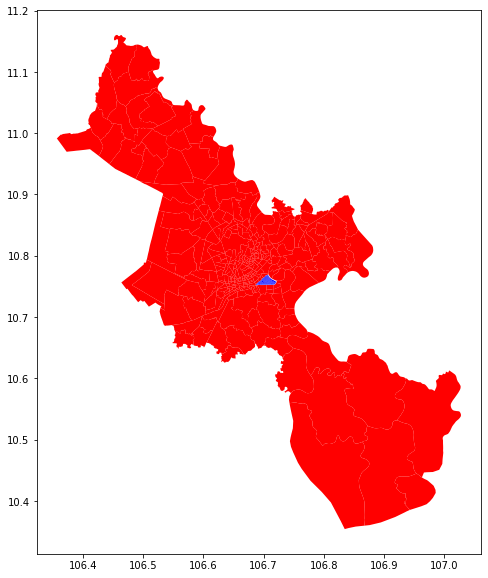

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(10,10))
external_zones.plot(ax=ax, color='red')
lu.plot(ax=ax, color='blue')

In [ ]:
# !pip uninstall geopandas
# !pip install pandas fiona shapely pyproj rtree
# !pip install geopandas

In [ ]:
search_radius=1200 # roughly 15 minutes walking

#### Define the accessibility metrics we are interested in, their min and max values and the column which is used for weighting the results.

In [ ]:
prox_metrics={
    'Residential Access': {'column':'res_total','min': 0, 'max': 500000, 'from': 'emp_total'},
    'Employment Access': {'column':'emp_total','min': 0, 'max': 5000000, 'from': 'res_total'},
    'Education Access': {'column':'emp_naics_61','min': 0, 'max': 50000, 'from': 'res_total'},
    'Healthcare Access': {'column':'emp_naics_62','min': 0, 'max': 50000, 'from': 'res_total'}}

### First aggregate access to the external zones (from wards)

In [ ]:
closest_node_ids_external = net.get_node_ids(x_col=external_zones['x_centroid'], y_col=external_zones['y_centroid'])

for name in prox_metrics:
    net.set(closest_node_ids_external, 
            variable=external_zones[prox_metrics[name]['column']], 
            name='{}_external'.format(name))

Removed 106 rows because they contain missing values
Removed 105 rows because they contain missing values
Removed 105 rows because they contain missing values
Removed 105 rows because they contain missing values


In [ ]:
external_access={}
for name in prox_metrics:    
    external_access[name]=net.aggregate(distance=search_radius, type="sum", 
                        decay="linear", name='{}_external'.format(name),
                        imp_name='distance')

### Then aggregate access to the internal zones (from LU file)

In [ ]:
closest_node_ids_internal = net.get_node_ids(x_col=lu['x_centroid'], y_col=lu['y_centroid'])

for name in prox_metrics:
    net.set(closest_node_ids_internal, 
            variable=lu[prox_metrics[name]['column']], 
            name='{}_internal'.format(name))

In [ ]:
internal_access={}
for name in prox_metrics:    
    internal_access[name]=net.aggregate(distance=search_radius, type="sum", 
                        decay="linear", name='{}_internal'.format(name),
                        imp_name='distance')

### Add the access to external POIs to the acess to internal POIs to get the total access to each POI

In [ ]:
overall_access={name: internal_access[name]+external_access[name] for name in internal_access}

#### Plot some of the results for illustration (Table area only)

In [ ]:
internal_bbox=lu.total_bounds

In [ ]:
table_node_ids=[ind for ind, n in nodes_df.iterrows() if (
    (n['lon']>internal_bbox[0]) and 
    (n['lon']<internal_bbox[2]) and 
    (n['lat']>internal_bbox[1]) and
    (n['lat']<internal_bbox[3]))]

In [ ]:
def create_gdf_access(nodes_df, access_dict):
    nodes_gdf=gpd.GeoDataFrame(data=access_dict,geometry=gpd.points_from_xy(
        nodes_df['lon'], nodes_df['lat'], crs='EPSG:4326'))
    return nodes_gdf
    
def plot_gdf_access(gdf, to):
    fig, ax=plt.subplots(1, figsize=(12,10))
    gdf.plot(column=to, ax=ax, legend=True)

In [ ]:
overall_access_table_only={x: overall_access[x][table_node_ids] for x in overall_access}

In [ ]:
gdf_access=create_gdf_access(nodes_df.loc[table_node_ids],
                             overall_access_table_only)

Employment

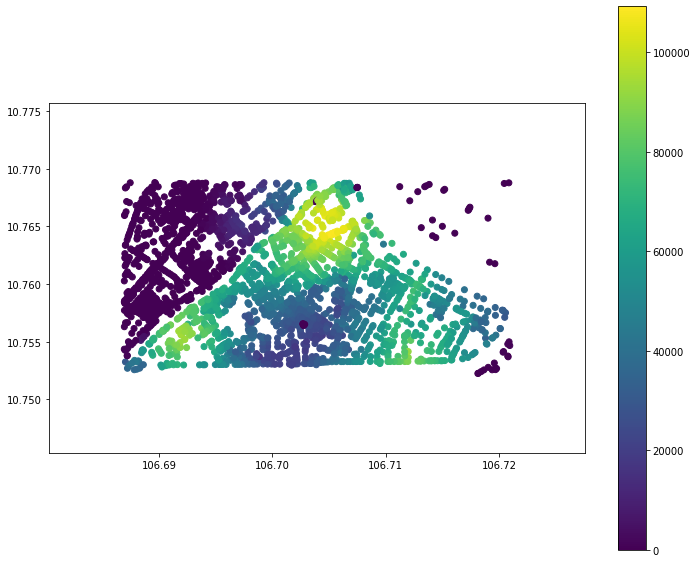

In [ ]:
plot_gdf_access(gdf_access, 'Employment Access')

Residential

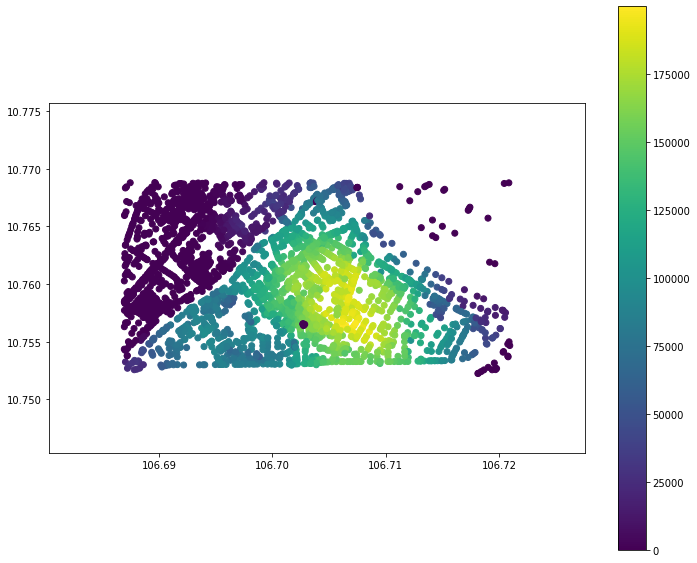

In [ ]:
plot_gdf_access(gdf_access, 'Residential Access')

In [ ]:
np.array([overall_access_table_only[x] for x in overall_access_table_only]).T.shape

(3041, 4)

Create some different output formats for the access heatmaps

In [ ]:
access_table=np.column_stack([nodes_df.loc[table_node_ids, ['lat', 'lon']], 
                              np.array([overall_access_table_only[x] for x in overall_access_table_only]).T])

In [ ]:
import pandas as pd
access_table=pd.DataFrame(overall_access_table_only)
access_table=access_table.merge(nodes_df, left_index=True, right_index=True)
access_table

,Residential Access,Employment Access,Education Access,Healthcare Access,lon,lat,id
id,,,,,,,
366367342,116151.750067,105172.871642,1392.320878,549.773542,106.706294,10.764703,366367342
366369352,194101.581113,48530.333968,1071.001937,129.401553,106.707950,10.756230,366369352
366370535,56247.380890,43319.038961,894.613528,19.080976,106.718253,10.756817,366370535
366374994,0.000000,0.000000,0.000000,0.000000,106.714139,10.764196,366374994
366378475,82997.258011,24601.016142,631.965131,329.362463,106.699543,10.754323,366378475
...,...,...,...,...,...,...,...
8360062380,23068.099989,43691.778069,403.262638,67.690641,106.716582,10.758707,8360062380
8360084685,66680.563173,57495.535301,1058.205150,69.621528,106.716645,10.757637,8360084685
8705344033,124854.928194,62135.979643,1037.541869,573.706741,106.699598,10.760481,8705344033


##### Save a geojson which is compatible with the access layer of CityScope_JS

In [ ]:
access_var_list=overall_access.keys()
access_cs_js_format=gdf_access.copy().__geo_interface__
access_cs_js_format['properties']=list(access_var_list)
del(access_cs_js_format['bbox'])
for i_f, feat in enumerate(access_cs_js_format['features']):
    access_cs_js_format['features'][i_f]['properties']=[normalise_indicator(
        feat['properties'][var], prox_metrics[var]['min'], prox_metrics[var]['max']) for var in access_var_list]
    del(access_cs_js_format['features'][i_f]['bbox'])

## MIT Create a single access indicator for each POI

Compute a weighted average accross all nodes where each node is valued by the people coming to the POI from this node. For example, when computing accessibility to employment or amenities, we weight the accessibility at each node by how many people live at this node. For accessibility to residential, we weight by how many people work there. <br>
The 'from' variable for each access metric was already specified in the prox_metrics dictionary.<br>

A simple 'hack' to get the number of people employed/living at each node is to 'aggregate' with a search_radius of 1 meter. <br>

We can ignore the external zones for this

In [ ]:
sources={}
all_source_columns=set([prox_metrics[name]['from'] for name in prox_metrics])
all_source_columns
for column in all_source_columns:
    net.set(closest_node_ids_internal, 
            variable=lu[column], 
            name='{}_source'.format(column))
    sources[column]=net.aggregate(distance=1, type="sum", 
                        decay="linear", name='{}_source'.format(column),
                        imp_name='distance')

In [ ]:
weighted_access={}
for name in prox_metrics:
    from_var=prox_metrics[name]['from']
    total_from=sources[from_var].sum()
    if total_from==0:
        weighted_access[name]=0
    else:
        weighted_access[name]=(overall_access[name].multiply(sources[from_var])).sum()/total_from

In [ ]:
weighted_access

{'Education Access': 915.1935170138285,
 'Employment Access': 60976.46050362212,
 'Healthcare Access': 247.56180802406885,
 'Residential Access': 91687.29417203557}

In [ ]:
indicators = []
for name in weighted_access:
    indicators.append({
        'raw_value': weighted_access[name],
        'value': normalise_indicator(weighted_access[name], prox_metrics[name]['min'], prox_metrics[name]['max']),
        'name': name,
        'type': 'radar'    
})
indicators

[{'name': 'Residential Access',
  'raw_value': 91687.29417203557,
  'type': 'radar',
  'value': 0.18337458834407114},
 {'name': 'Employment Access',
  'raw_value': 60976.46050362212,
  'type': 'radar',
  'value': 0.012195292100724424},
 {'name': 'Education Access',
  'raw_value': 915.1935170138285,
  'type': 'radar',
  'value': 0.01830387034027657},
 {'name': 'Healthcare Access',
  'raw_value': 247.56180802406885,
  'type': 'radar',
  'value': 0.004951236160481377}]

## MIT Mobility Model

We will use the Simulation class from the CS_Spatial_Modules submodule

In [ ]:
import sys
sys.path.insert(0,'../modules/CS_Spatial_Modules')
import Simulation

In [ ]:
lu=lu.set_index('OBJECTID')

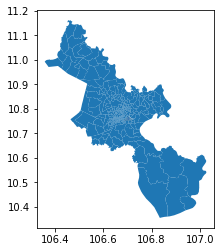

In [ ]:
combined_zones=external_zones.append(lu).fillna(0)
combined_zones.plot()

### Create zone to zone distance matrix

In [ ]:
combined_zones['node']=net.get_node_ids(
                x_col=combined_zones['x_centroid'],y_col=combined_zones['y_centroid'])   

Takes a few minutes:

In [ ]:
zone_index=combined_zones.index
all_o_geoid=[]
for ind in zone_index:
    all_o_geoid.extend([ind]*len(zone_index))
all_d_geoid=list(zone_index)*len(zone_index)

all_o_nodes=combined_zones.loc[all_o_geoid,'node']
all_d_nodes=combined_zones.loc[all_d_geoid,'node']

all_dists=net.shortest_path_lengths(all_o_nodes,all_d_nodes, imp_name='distance')

In [ ]:
all_dists_mat=np.reshape(all_dists, (len(zone_index), len(zone_index)))
dist_mat_df=pd.DataFrame(all_dists_mat)
dist_mat_df.columns=combined_zones.index
dist_mat_df.index=combined_zones.index

Replace zeros with a small distance to avid numerical issues

In [ ]:
dist_mat_df=dist_mat_df.replace(0, 50)

In [ ]:
dist_mat_df.head()

,26734,26740,26752,26746,26755,26761,26758,26749,27121,27124,27151,27157,27148,27154,27301,27307,27325,27334,27337,27340,27343,27370,27379,27382,27376,27361,27352,27355,26737,27367,27331,27316,27388,27415,27421,27427,27358,27364,27385,27430,...,2103,2104,2115,2139,2140,2141,2142,2143,2144,2145,2146,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2163,2164,2165,2166,2167,2168,2169,2170,2171,2179,2181,2209,2213,2215,2216,2226
26734,50.000,457.982,457.982,457.982,457.982,457.982,457.982,457.982,50.000,50.000,457.982,457.982,457.982,457.982,457.982,457.982,457.982,457.982,457.982,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,457.982,50.000,50.000,457.982,457.982,50.000,50.000,50.000,50.000,50.000,50.000,50.000,...,71192.841,71039.905,69544.339,71038.650,69719.837,70111.565,70224.770,70053.340,70443.691,70493.974,71208.094,71336.472,69833.935,69787.497,69771.824,69770.012,69787.497,69608.613,69536.275,69565.853,71039.744,70983.322,70551.135,69974.605,70858.899,70451.888,71842.216,71800.100,71870.586,70950.300,69890.363,70493.835,70514.456,72096.901,70827.249,70249.722,69604.546,71489.986,72115.819,70132.857
26740,457.982,50.000,50.000,50.000,50.000,50.000,50.000,50.000,457.982,457.982,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,457.982,457.982,457.982,457.982,457.982,457.982,457.982,457.982,457.982,50.000,457.982,457.982,50.000,50.000,457.982,457.982,457.982,457.982,457.982,457.982,457.982,...,71428.597,71275.661,69780.095,71274.406,69955.593,70347.321,70460.526,70289.096,70679.447,70729.730,71443.850,71572.228,70069.691,70023.253,70007.580,70005.768,70023.253,69844.369,69772.031,69801.609,71275.500,71219.078,70786.891,70210.361,71094.655,70687.644,72077.972,72035.856,72106.342,71186.056,70126.119,70729.591,70750.212,72332.657,71063.005,70485.478,69840.302,71725.742,72351.575,70368.613
26752,457.982,50.000,50.000,50.000,50.000,50.000,50.000,50.000,457.982,457.982,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,457.982,457.982,457.982,457.982,457.982,457.982,457.982,457.982,457.982,50.000,457.982,457.982,50.000,50.000,457.982,457.982,457.982,457.982,457.982,457.982,457.982,...,71428.597,71275.661,69780.095,71274.406,69955.593,70347.321,70460.526,70289.096,70679.447,70729.730,71443.850,71572.228,70069.691,70023.253,70007.580,70005.768,70023.253,69844.369,69772.031,69801.609,71275.500,71219.078,70786.891,70210.361,71094.655,70687.644,72077.972,72035.856,72106.342,71186.056,70126.119,70729.591,70750.212,72332.657,71063.005,70485.478,69840.302,71725.742,72351.575,70368.613
26746,457.982,50.000,50.000,50.000,50.000,50.000,50.000,50.000,457.982,457.982,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,457.982,457.982,457.982,457.982,457.982,457.982,457.982,457.982,457.982,50.000,457.982,457.982,50.000,50.000,457.982,457.982,457.982,457.982,457.982,457.982,457.982,...,71428.597,71275.661,69780.095,71274.406,69955.593,70347.321,70460.526,70289.096,70679.447,70729.730,71443.850,71572.228,70069.691,70023.253,70007.580,70005.768,70023.253,69844.369,69772.031,69801.609,71275.500,71219.078,70786.891,70210.361,71094.655,70687.644,72077.972,72035.856,72106.342,71186.056,70126.119,70729.591,70750.212,72332.657,71063.005,70485.478,69840.302,71725.742,72351.575,70368.613
26755,457.982,50.000,50.000,50.000,50.000,50.000,50.000,50.000,457.982,457.982,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,50.000,457.982,457.982,457.982,457.982,457.982,457.982,457.982,457.982,457.982,50.000,457.982,457.982,50.000,50.000,457.982,457.982,457.982,457.982,457.982,457.982,457.982,...,71428.597,71275.661,69780.095,71274.406,69955.593,70347.321,70460.526,70289.096,70679.447,70729.730,71443.850,71572.228,70069.691,70023.253,70007.580,70005.768,70023.253,69844.369,69772.031,69801.609,71275.500,71219.078,70786.891,70210.361,71094.655,70687.644,72077.972,72035.856,72106.342,71186.056,70126.119,70729.591,70750.212,72332.657,71063.005,70485.478,69840.302,71725.742,72351.575,70368.613


In [ ]:
# dist_mat_df.to_csv('../outputs/dist_mat_s{}.csv'.format(s))

In [ ]:
# dist_mat={}
# zone_index=combined_zones.index
# for o_ind in zone_index:
#     o_node=combined_zones.loc[o_ind]['node']
#     d_nodes=[combined_zones.loc[d_ind]['node'] for d_ind in zone_index]
#     dists=net.shortest_path_lengths([o_node]*len(d_nodes),d_nodes, imp_name='distance')
#     dists=[d if d>0 else 100 for d in dists ] # in case of same closest node
#     dist_mat[o_ind]={zone_index[d]: dists[d] for d in range(len(dists))}

In [ ]:
# json.dump(dist_mat, open('../outputs/dist_mat_s{}'.format(s),'w'))
# dist_mat=json.load(open('../outputs/dist_mat_s{}'.format(s)))

### Create population based on land uses

In [ ]:
import random
import numpy as np
import pandas as pd

def prob_floor(num):
    """
    Probabilistic "rounding" function
    eg. if num==1.2: this function will return 
    - 1.0 80% of the time 
    - 2.0 20% of the time
    """
    result=int(num)
    remainder=num-result
    if random.uniform(0, 1)<remainder:
        result+=1
    return result


def sample_home_locations(zones, work_geoid, dist_mat_df, n, beta=0.9):
    """ 
    Sample home locations using a simple gravity model.
    Attractiveness is proportional to the total residential capacity
    beta controls the distance decay
    """
    attraction=zones['res_total']
    impedance=[dist_mat_df.loc[hid,work_geoid] for hid in zones.index]
    weights=np.divide(attraction,np.power(impedance, beta))
    return np.random.choice(
        zones.index, replace=True, p=weights/sum(weights), size=n)

In [ ]:
industry_columns=[col for col in lu.columns if 'emp_naics' in col]
res_income_columns=[col for col in lu.columns if 'res_income' in col]

In [ ]:
def create_simpop(zones, sample_fraction=0.01):
    simpop=[]
    for geoid, row in zones.iterrows():
        for naics_col in industry_columns:
            naics_code=naics_col.split('emp_naics_')[1]
            capacity=row[naics_col]*sample_fraction
            n_workers=prob_floor(capacity)
            home_locations=sample_home_locations(zones, geoid, dist_mat_df, n_workers, beta=0.9)
            # TODO: age and income sampling should be weighted according to NAICS
            # i.e. people working in retail have a different age and income distribution to professionals
            earnings=np.random.choice(['1', '2', '3', '4'], replace=True,size=n_workers)
            age=np.random.choice(range(20,70), replace=True,size=n_workers)
            for i_w in range(n_workers):
                simpop.append({'work_geoid': geoid,'home_geoid': home_locations[i_w],
                                                   'naics': naics_code, 'earnings': earnings[i_w],
                                                  'age': age[i_w]})
    return simpop

In [ ]:
simpop=create_simpop(combined_zones, sample_fraction=0.0001)
simpop_df=pd.DataFrame(simpop)

#### Only include people who either live OR work in the SIMULATION (table) area

In [ ]:
print(len(simpop_df))
simpop_df=simpop_df.loc[((simpop_df['home_geoid'].isin(lu.index))|
                         (simpop_df['work_geoid'].isin(lu.index)))]
print(len(simpop_df))

50
50


In [ ]:
simpop_df=simpop_df.sample(50)

### Load the mode choice model

In [ ]:
import pickle
import json
mc_model=pickle.load(open('../outputs/mode_choice_model.p', 'rb'))
model_description=json.load(open('../outputs/mc_model_features.json'))

class Logistic_Mode_Choice_model():
    def __init__(self, mc_model, model_description):
        self.options=model_description['mode_order']
        self.features=model_description['features']
        self.dummy_map=model_description['dummy_map']
        self.model=mc_model
    
    def predict_modes(self, all_trips_df):
        data=all_trips_df.copy()
        for attr in self.dummy_map:
            dummys=pd.get_dummies(data[attr], prefix=self.dummy_map[attr])
            for col in dummys.columns:
                data[col]=dummys[col]
        for feat in self.features:
            if not feat in data.columns:
                print('{} not in data'.format(feat))
                data[feat]=0
        X=data[self.features]
        y_pred_proba=self.model.predict_proba(X)
        # Do all probabilistic samples with single call random number generator
        y_pred_proba_cum=np.cumsum(y_pred_proba, axis=1)
        p_cut=np.random.uniform(0, 1, len(data))
        y_pred=[self.options[np.argmax(y_pred_proba_cum[i]>p_cut[i])] for i in range(len(data))]
#         y_pred=[self.options[np.random.choice(range(len(y_pred_proba[i])), size=1, replace=True, p=y_pred_proba[i]
#                                 )[0]] for i in range(len(y_pred_proba))]
        all_trips_df['mode']=y_pred
        return all_trips_df

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Mode and profile descriptions

In [ ]:
mode_colors=['#7fc97f',
'#beaed4',
'#fdc086',
'#ffff99',
'#386cb0',
'#f0027f',
'#bf5b17']

mode_descriptions=[{'name': model_description['mode_order'][i], 'color': mode_colors[i]
                  } for i in range(len(model_description['mode_order']))]

profile_descriptions = [{"name": '1',
                        'color': "#7fc97f"},
                         {"name": '2',
                        'color': "#beaed4"},
                         {"name": '3',
                        'color': "#fdc086"},
                        {"name": '4',
                        'color': "#ffff99"},
                        ]

### Create Mobility System

All modes use same network but with different average speeds

In [ ]:
edges_df['travel_time_drive']=edges_df['distance']/(50000/3600) # 50km/hr
edges_df['travel_time_walk']=edges_df['distance']/(5000/3600) # 5km/hr
edges_df['travel_time_cycle']=edges_df['distance']/(12000/3600) # 12km/hr

net=pandana.Network(nodes_df["lon"], nodes_df["lat"], edges_df["from"], edges_df["to"],
                 edges_df[["distance", "travel_time_drive", "travel_time_walk", "travel_time_cycle"]])

In [ ]:
networks={}
networks['drive']=Simulation.PdnaNetwork(net)

building link attribute lookup


In [ ]:
mode_dicts={}
mode_dicts['Motorcycle']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}
mode_dicts['Bicycle']={'target_network_id': 'drive','travel_time_metric': 'travel_time_cycle'}
mode_dicts['Electric bicycle']={'target_network_id': 'drive','travel_time_metric': 'travel_time_cycle'}
mode_dicts['Walking']={'target_network_id': 'drive','travel_time_metric': 'travel_time_walk'}
mode_dicts['Bus']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}
mode_dicts['Car']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}
mode_dicts['Others']={'target_network_id': 'drive','travel_time_metric': 'travel_time_drive'}

In [ ]:
modes={mode: Simulation.Mode(mode_dicts[mode]) for mode in mode_dicts}
mob_sys=Simulation.MobilitySystem(modes=modes, networks=networks)

In [ ]:
sim=Simulation.Simulation(simpop_df, mob_sys, combined_zones, sim_geoids=lu.index,
            mode_descriptions=mode_descriptions, profile_descriptions=profile_descriptions)
sim.set_choice_models(mode_chooser=Logistic_Mode_Choice_model(mc_model, model_description))

Getting internal nodes
Finding closest nodes to every zone centroid


### Run the Simulation

In [ ]:
simpop_df=sim.create_simple_HWOWH_schedules(simpop_df)
all_trips_df=sim.create_trip_table(simpop_df)
all_trips_df['distance']=sim.mob_sys.networks['drive'].net.shortest_path_lengths(
    [n[0] for n in all_trips_df['from_possible_nodes_drive']],
    [n[0] for n in all_trips_df['to_possible_nodes_drive']],
    imp_name='distance')
all_trips_df=sim.mode_chooser.predict_modes(all_trips_df)
route_table=sim.get_routes_table(all_trips_df)
deckgl_trips=sim.routes_to_deckgl_trip(route_table)

emp_naics_11 not in data
emp_naics_21 not in data
emp_naics_23 not in data
emp_naics_48-49 not in data
emp_naics_52 not in data
emp_naics_61 not in data
emp_naics_62 not in data
emp_naics_81 not in data


../modules/CS_Spatial_Modules/Simulation.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_table_this_mode['node_path']=routes['node_path']
../modules/CS_Spatial_Modules/Simulation.py:408: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_table_this_mode['attributes']=routes['attributes']


#### Create additional outputs

In [ ]:
route_gdf=sim.route_table_to_geo(route_table)
start_day_time_stamp=1626307200
trips_geo=sim.route_gdf_to_trips_geojson(route_gdf[['naics','earnings','age', 'mode', 'line_string', 'start_time', 'attributes', 'node_path']], 
                                         start_day_time_stamp=start_day_time_stamp)

#### Calculate a Mobility CO2 Indicator

Distances by mode (filtering out very large distances due to pandana failure to find route)

In [ ]:
distances_by_mode=route_table.loc[route_table['distance']<1e6].groupby('mode')['distance'].sum()
distances_by_mode

mode
Bicycle              15830.673
Bus                   4808.350
Car                   1856.023
Electric bicycle       410.567
Motorcycle          265589.685
Others               18618.855
Walking              14981.719
Name: distance, dtype: float64

Values below are guesses- need to be replaced by estimates specific to Vietnam/HCMC

In [ ]:
co2_kg_per_meter={'Motorcycle': 0.26/1000,
                 'Car': 0.27/1000,
                 'Electric bicycle': 0.1/1000,
                 'Bicycle': 0,
                 'Walking': 0,
                 'Bus': 0.2/1000,
                 'Others': 0.27/1000}

In [ ]:
total_co2=sum([distances_by_mode[mode]*co2_kg_per_meter[mode] for mode in distances_by_mode.index])

In [ ]:
co2_kg_per_person_day=total_co2/len(simpop_df)
co2_kg_per_person_day

1.5116852372000005

Normalise the indicator- note that the min and max are flipped because smaller is better

In [ ]:
co2_max=6
co2_min=2

In [ ]:
co2_ind_norm = normalise_indicator(co2_kg_per_person_day, min_value=co2_max, max_value=co2_min)
1/co2_ind_norm

0.8912030932306163

In [ ]:
indicators.append({
        'raw_value': co2_kg_per_person_day,
        'value': co2_ind_norm,
        'name': 'Sustainable Mobility',
        'type': 'radar'    
})

In [ ]:
indicators

[{'name': 'Residential Access',
  'raw_value': 91687.29417203557,
  'type': 'radar',
  'value': 0.18337458834407114},
 {'name': 'Employment Access',
  'raw_value': 60976.46050362212,
  'type': 'radar',
  'value': 0.012195292100724424},
 {'name': 'Education Access',
  'raw_value': 915.1935170138285,
  'type': 'radar',
  'value': 0.01830387034027657},
 {'name': 'Healthcare Access',
  'raw_value': 247.56180802406885,
  'type': 'radar',
  'value': 0.004951236160481377},
 {'name': 'Sustainable Mobility',
  'raw_value': 1.5116852372000005,
  'type': 'radar',
  'value': 1.1220786907}]

In [ ]:
#s0
print(co2_kg_per_person_day)
print(co2_ind_norm)
print(1/co2_ind_norm)

1.5116852372000005
1.1220786907
0.8912030932306163


In [ ]:
#s0: 1.5116852372000005
#s2: 1.7184060994000003
#s3: 1.5218902506


# Commit Density & Diversity, Live-work Score


In [ ]:
from brix import Indicator, Handler
from numpy import log
from collections import Counter

In [ ]:
#hard values
norm_housing_density = {
    1: {0: 1.0, 2: 1.0, 3: 1.0},
    2: {0: 0.0, 2: 0.0, 3: 0.0},
    4: {0: 0.6429672358002947, 2: 0.7453366112122525, 3: 0.6915975565740673},
    7: {0: 0.15340622464528594, 2: 0.15340622464528594, 3: 0.15340622464528594},
}

norm_amenity_density = {
    1: {0: 1.0, 2: 1.0, 3: 1.0},
    2: {0: 0.0, 2: 0.0, 3: 0.0},
    4: {0: 0.9630769855914374, 2: 0.9630769855914374, 3: 0.9630769855914374},
    7: {0: 0.7678277157947919, 2: 0.7678277157947919, 3: 0.7678277157947919},
} #same for 3 scenarios

norm_emp_density = {
    1: {0: 0.4652039933320546, 2: 0.4652039933320546, 3: 0.4652039933320546},
    2: {0: 1.0, 2: 1.0, 3: 1.0},
    4: {0: 0.11407065910392224, 2: 0.13753243613811958, 3: 0.20772863319763787},
    7: {0: 0.0, 2: 0.0, 3: 0.0},
}

housing_diversity = {
    1: {0: 0.6527926701777532, 2: 0.6527926701777532, 3: 0.6527926701777532},
    2: {0: 0.26693350649186237, 2: 0.26693350649186237, 3: 0.26693350649186237},
    4: {0: 0.611441904982808, 2: 0.6609037812997277, 3: 0.6476164312502846},
    7: {0: 0.4791422973952734, 2: 0.4791422973952734, 3: 0.4791422973952734},
}

amenity_diversity = {
    1: {0: 0.16376270231119844, 2: 0.16376270231119844, 3: 0.16376270231119844},
    2: {0: 0.07687109016438094, 2: 0.07687109016438094, 3: 0.07687109016438094},
    4: {0: 0.16921554953852308, 2: 0.16921554953852308, 3: 0.16921554953852308},
    7: {0: 0.07068552120091513, 2: 0.07068552120091513, 3: 0.07068552120091513},
} #same for 3 scenarios

emp_diversity = {
    1: {0: 0.7943630572957392, 2: 0.7943630572957392, 3: 0.7943630572957392},
    2: {0: 0.7056630928947264, 2: 0.7056630928947264, 3: 0.7056630928947264},
    4: {0: 0.7637618494664363, 2: 0.7447191095272313, 3: 0.7328403253055698},
    7: {0: 0.6758740565049, 2: 0.6758740565049, 3: 0.6758740565049},
}

live_work_scores = {
    1: {0: 0.9819512670483682, 2: 0.9819512670483682, 3: 0.9819512670483682},
    2: {0: 0.35781412852075406, 2: 0.35781412852075406, 3: 0.35781412852075406},
    4: {0: 0.4431096722060759, 2: 0.4620509234399493, 3: 0.6183287017985014},
    7: {0: 0.16465853097420305, 2: 0.16465853097420305, 3: 0.16465853097420305},
}

norm_mobility = {
    4: {0: 0.44423336867647045, 2: 0.36823305169117637, 3: 0.44048152551470593}
}

In [ ]:
dist_idx_ref = 4
sim_idx_ref = 0

reference = {
    'Housing Density': norm_housing_density[dist_idx_ref][sim_idx_ref],
    'Amenity Density': norm_amenity_density[dist_idx_ref][sim_idx_ref],
    'Employment Density': norm_emp_density[dist_idx_ref][sim_idx_ref],
    'Housing Diversity': housing_diversity[dist_idx_ref][sim_idx_ref],
    'Amenity Diversity': amenity_diversity[dist_idx_ref][sim_idx_ref],
    'Employment Diversity': emp_diversity[dist_idx_ref][sim_idx_ref],
    'Live-Work Score': live_work_scores[dist_idx_ref][sim_idx_ref],
}

In [ ]:
dist_idx = 4
sim_idx = 0

class HousingDensity(Indicator):
	def setup(self):
		self.name = 'Housing Density'
		self.requires_geogrid_props = False
		self.viz_type = 'radar'

	def return_indicator(self, geogrid_data):
		return norm_housing_density[dist_idx][sim_idx] #HousingDensity of Q4, s0

class AmenityDensity(Indicator):
	def setup(self):
		self.name = 'Amenity Density'
		self.requires_geogrid_props = False
		self.viz_type = 'radar'

	def return_indicator(self, geogrid_data):
		return norm_amenity_density[dist_idx][sim_idx] #AmenityDensity of Q4

class EmploymentDensity(Indicator):
	def setup(self):
		self.name = 'Employment Density'
		self.requires_geogrid_props = False
		self.viz_type = 'radar'

	def return_indicator(self, geogrid_data):
		return norm_emp_density[dist_idx][sim_idx] #HEmploymentDensity of Q4, s0

class HousingDiversity(Indicator):
	def setup(self):
		self.name = 'Housing Diversity'
		self.requires_geogrid_props = False
		self.viz_type = 'radar'

	def return_indicator(self, geogrid_data):
		return housing_diversity[dist_idx][sim_idx] #HousingDiversity of Q4, s0

class AmenityDiversity(Indicator):
	def setup(self):
		self.name = 'Amenity Diversity'
		self.requires_geogrid_props = False
		self.viz_type = 'radar'

	def return_indicator(self, geogrid_data):
		return amenity_diversity[dist_idx][sim_idx] #AmenityDiversity of Q4

class EmploymentDiversity(Indicator):
	def setup(self):
		self.name = 'Employment Diversity'
		self.requires_geogrid_props = False
		self.viz_type = 'radar'

	def return_indicator(self, geogrid_data):
		return emp_diversity[dist_idx][sim_idx] #EmploymentDiversity of Q4, s0

class LiveWorkScore(Indicator):
	def setup(self):
		self.name = 'Live-Work Score'
		self.requires_geogrid_props = False
		self.viz_type = 'radar'

	def return_indicator(self, geogrid_data):
		return live_work_scores[dist_idx][sim_idx] #live_work_score of Q4, s0

class Mobility(Indicator):
	def setup(self):
		self.name = 'Mobility'
		self.requires_geogrid_props = False
		self.viz_type = 'radar'

	def return_indicator(self, geogrid_data):
		return norm_mobility[dist_idx][sim_idx] #norm_mobility of Q4, s0

In [ ]:
# H = Handler('hcm_scenario_0', reference=reference)
geogrid_data = H.get_geogrid_data()

housing_den = HousingDensity()
amenity_den = AmenityDensity()
employment_den = EmploymentDensity()
housing_div = HousingDiversity()
amenity_div = AmenityDiversity()
employment_div = EmploymentDiversity()
lw_score = LiveWorkScore()
mobility = Mobility()

H.add_indicator(housing_den)
H.add_indicator(amenity_den)
H.add_indicator(employment_den)
H.add_indicator(housing_div)
H.add_indicator(amenity_div)
H.add_indicator(employment_div)
H.add_indicator(lw_score)
H.add_indicator(mobility)

H.listen()

# Commit Static-Heatmap Accessibility

In [ ]:
import numpy as np
from geopy.distance import distance as geodistance

class Accessibility(Indicator):
        def setup(self):
                self.name = 'Accessibility'
                self.indicator_type = 'heatmap'

        def return_indicator(self, geogrid_data):
                cells = [cell for cell in geogrid_data if cell['name'] != 'Water']
                features = []
                for index, cell in enumerate(cells):
                        cell_coords = list(np.mean(cell['geometry']['coordinates'][0],0) )
                        feature = {}
                        feature['geometry'] = {'coordinates': cell_coords,'type': 'Point'}
                        feature['properties'] = {'Park': float(Accessibilities['park'][cell['id']]) / max(Accessibilities['park']),
                                                 'Medical': float(Accessibilities['medical'][cell['id']]) / max(Accessibilities['medical']),
                                                 'Education': float(Accessibilities['education'][cell['id']]) / max(Accessibilities['education']),
                                                 'Commercial': float(Accessibilities['commercial'][cell['id']]) / max(Accessibilities['commercial'])}
                        features.append(feature)
                out = {'type':'FeatureCollection', 'features':features}
                return out

H = Handler('hcm_scenario_0') #link to a table
geogrid_data = H.get_geogrid_data()
A = Accessibility() 
H.add_indicator(A)
H.listen()

https://cityio.media.mit.edu/api/tables/list/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/meta/hashes/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/GEOGRIDDATA/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/GEOGRID/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/GEOGRIDDATA/ Attempt: 0


/usr/local/lib/python3.7/dist-packages/brix/classes.py:1570: UserWarning: You have unlinked indicators: Employment Density, Amenity Density, Amenity Diversity, Park, Commercial, Live-Work Score, Medical, Housing Density, Housing Diversity, Education, Employment Diversity
  warn(f'You have unlinked indicators: {unlinked_indicators}')


Table URL: https://cityscope.media.mit.edu/CS_cityscopeJS/?cityscope=hcm_scenario_3
Testing indicators
https://cityio.media.mit.edu/api/table/hcm_scenario_3/GEOGRIDDATA/ Attempt: 0
Performing initial update
Updating geogrid_data
https://cityio.media.mit.edu/api/table/hcm_scenario_3/GEOGRIDDATA/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/meta/hashes/ Attempt: 0
Updating table with hash: 5p24zcWSTS1PQJ4fjT16haGgeLQgZuSwG3r37RKGvYiS
https://cityio.media.mit.edu/api/table/hcm_scenario_3/GEOGRIDDATA/ Attempt: 0
Done with update
Local grid hash: 5p24zcWSTS1PQJ4fjT16haGgeLQgZuSwG3r37RKGvYiS
https://cityio.media.mit.edu/api/table/hcm_scenario_3/meta/hashes/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/meta/hashes/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/meta/hashes/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/meta/hashes/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/meta/hashes/ Attempt:

KeyboardInterrupt: ignored

# (ignored) Install Libraries

In order to use pandana package, need to upgrade numpy

In [ ]:
!pip install osmnet
!pip install pandana
!pip install folium
!pip install matplotlib==3.1.3

In [ ]:
# CityScope Brix
import brix

# Data analysis
import geopandas as gpd
import pandas as pd
import numpy as np

# Visualisations
import folium
import matplotlib.pyplot as plt

# osm and pandana
import osmnet
import pandana

### Initialise the brix handler for our CityScope table and plot the GEOGRIDDATA

In [ ]:
import pandas as pd
import pandana as pdna
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
W_accesstoSM = {}
Acessibilities = {}
num_pois = {}
for amenity in amenities:
  pois = all_pois[amenity]
  num_pois[amenity] = len(pois)
  dists = compute_closest_distance(wards.centroid, pois)
  #W_accesstoSM[amenity] = 1.0/(ward_pops * dists)
  #accesstoSM_norm = w_acesstoSM / np.max(w_acesstoSM)
  Acessibilities[amenity] = compute_accessibility(wards.centroid, pois)

# (ignore) Accessibility Heatmap: number of POIs in a radius of 500m

In [ ]:
def compute_closest_distance(centroids, pois):
  distances = []
  for j in centroids:
    distances.append(np.min([j.distance(x) for x in pois['geometry']]))
  return distances

def compute_accessibility(centroids, pois, max_dist=500):
  accessibility = []
  circles = centroids.buffer(max_dist)
  for j in circles:
    accessibility.append(np.sum([j.contains(x) for x in pois['geometry']]))
  return accessibility

In [ ]:
_

Compute accessibility for POIs in building level

In [ ]:
#idx = 0
#Acessibilities = {}
#num_pois = {}
#amenities = ['medical', 'park', 'education']
#for amenity in amenities:
#  print(amenity)
#  pois = all_pois[amenity]
#  num_pois[amenity] = len(pois)
#  Acessibilities[amenity] = compute_accessibility(dist4_buildings[idx].centroid, pois)

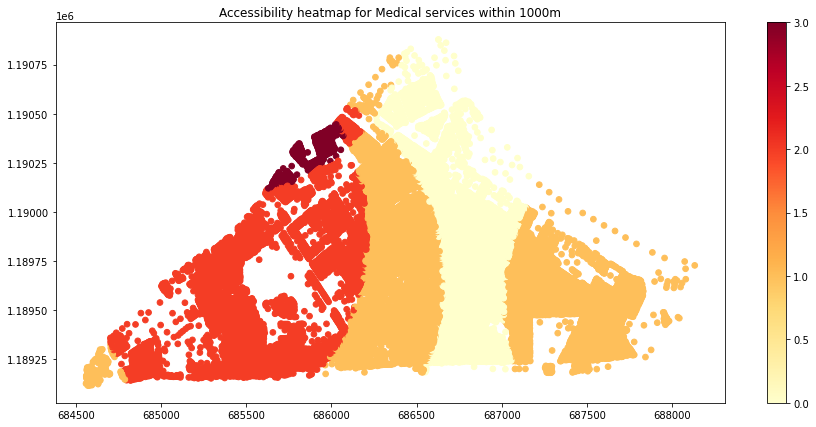

In [ ]:
amenity = 'park'
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Accessibility heatmap for Park services within 1000m')
plt.scatter(dist4_buildings[idx].centroid.geometry.x, dist4_buildings[idx].centroid.geometry.y, 
            c=Acessibilities[amenity], s=32, cmap='YlOrRd')

cb = plt.colorbar()
plt.show()

Compute accessibility for POIs in grid level

In [ ]:
from brix import Indicator, Handler
from brix.examples import Diversity, RandomIndicator
import random

grids = {}
for idx in [0, 2, 3]:
  H = Handler('hcm_scenario_{}'.format(idx), quietly=False)
  geo_data = H.get_geogrid_data(include_geometries=True)
  grids[idx] = geo_data.as_df().to_crs('EPSG:32648')
  grids[idx] = grids[idx][grids[idx]['name']!='Water']

https://cityio.media.mit.edu/api/tables/list/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_0/meta/hashes/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_0/GEOGRIDDATA/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_0/GEOGRID/ Attempt: 0
https://cityio.media.mit.edu/api/tables/list/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_2/meta/hashes/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_2/GEOGRIDDATA/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_2/GEOGRID/ Attempt: 0
https://cityio.media.mit.edu/api/tables/list/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/meta/hashes/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/GEOGRIDDATA/ Attempt: 0
https://cityio.media.mit.edu/api/table/hcm_scenario_3/GEOGRID/ Attempt: 0


In [ ]:
idx = 0
Acessibilities = {}
num_pois = {}
for amenity in amenities:
  print(amenity)
  pois = all_pois[amenity]
  num_pois[amenity] = len(pois)
  Acessibilities[amenity] = compute_accessibility(grids[idx].centroid, pois)
  Acessibilities[amenity] /= max(Acessibilities[amenity])

medical
park
education
commercial


In [ ]:
from brix import Indicator
import numpy as np
from geopy.distance import distance as geodistance

class Accessibility(Indicator):
        def setup(self):
                self.name = 'Accessibility'
                self.indicator_type = 'heatmap'

        def return_indicator(self,geogrid_data):
                #geogrid_data = geogrid_data[geogrid_data['name']!='Water']
                cells = [cell for cell in geogrid_data if cell['name']!='Water']
                features = []
                for i, cell in enumerate(cells):
                        cell_coords = list(np.mean(cell['geometry']['coordinates'][0],0) )
                        feature = {}
                        feature['geometry'] = {'coordinates': cell_coords,'type': 'Point'}
                        feature['properties'] = {"Park": float(Acessibilities['park'][i]), 
                                                 "Medical": float(Acessibilities['medical'][i]),
                                                 "Education": float(Acessibilities['education'][i]),
                                                 "Commercial": float(Acessibilities['commercial'][i])}
                        features.append(feature)

                out = {'type':'FeatureCollection','features':features}
                return out


H = Handler('hcm_scenario_0', quietly=False)
PA = Accessibility()
H.add_indicators([PA])
H.listen()

In [ ]:
np.average(Acessibilities['education'])

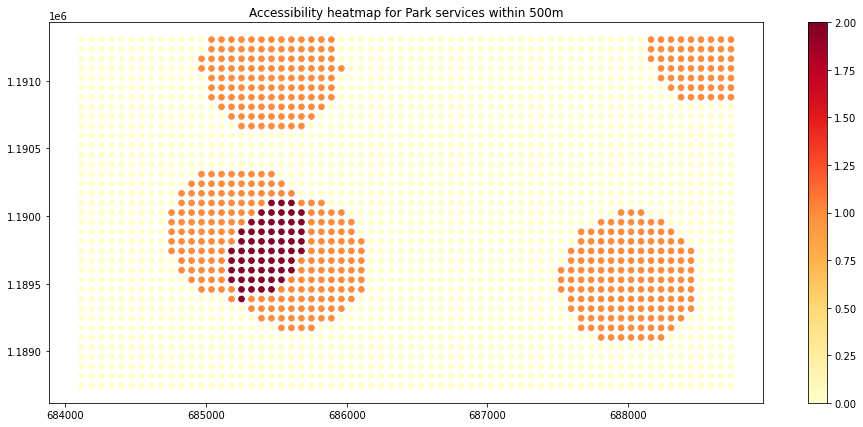

In [ ]:
amenity = 'park'
fig, ax = plt.subplots(figsize=(16,7))
plt.title('Accessibility heatmap for Park services within 500m')
plt.scatter(grids[idx].centroid.geometry.x, grids[idx].centroid.geometry.y, 
            c=Acessibilities[amenity], s=32, cmap='YlOrRd')

cb = plt.colorbar()
plt.show()

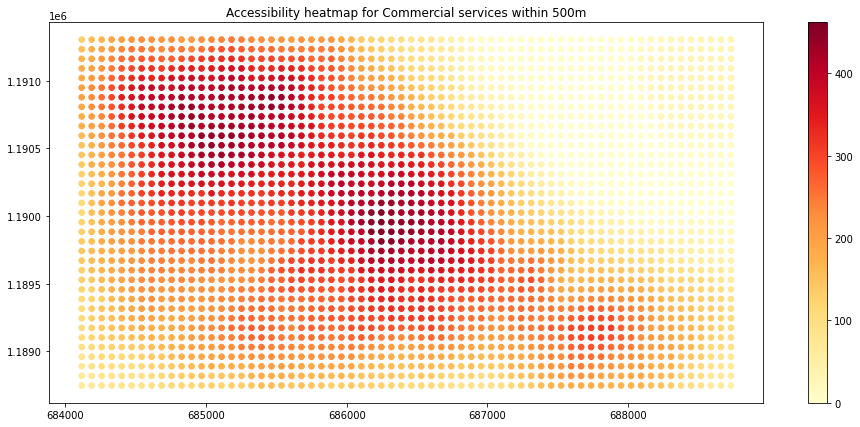

In [ ]:
amenity = 'commercial'
fig, ax = plt.subplots(figsize=(16,7))
plt.title('Accessibility heatmap for Commercial services within 500m')
plt.scatter(grids[idx].centroid.geometry.x, grids[idx].centroid.geometry.y, 
            c=Acessibilities[amenity], s=32, cmap='YlOrRd')

cb = plt.colorbar()
plt.show()

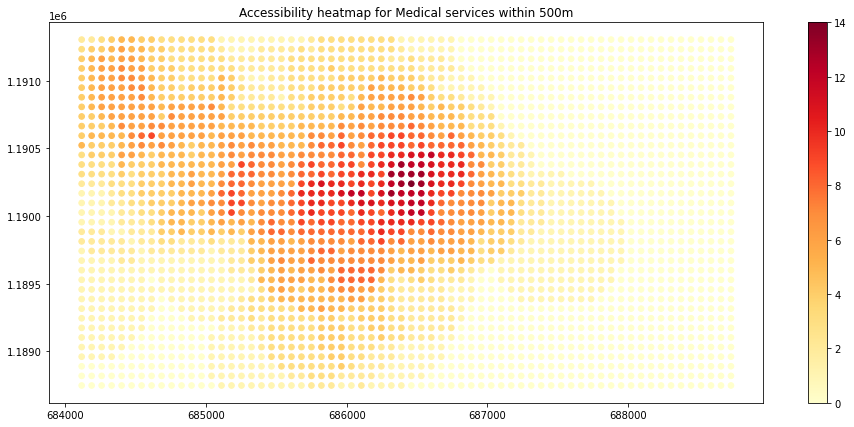

In [ ]:
amenity = 'medical'
fig, ax = plt.subplots(figsize=(16,7))
plt.title('Accessibility heatmap for Medical services within 500m')
plt.scatter(grids[idx].centroid.geometry.x, grids[idx].centroid.geometry.y, 
            c=Acessibilities[amenity], s=32, cmap='YlOrRd')

cb = plt.colorbar()
plt.show()

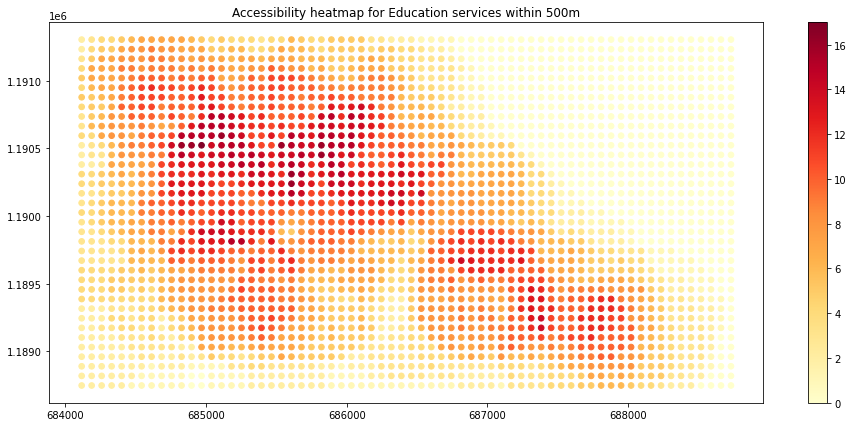

In [ ]:
amenity = 'education'
fig, ax = plt.subplots(figsize=(16,7))
plt.title('Accessibility heatmap for Education services within 500m')
plt.scatter(grids[idx].centroid.geometry.x, grids[idx].centroid.geometry.y, 
            c=Acessibilities[amenity], s=32, cmap='YlOrRd')

cb = plt.colorbar()
plt.show()